# Modeling

Author: Preeya Sawadmanod 

---
We are going to classify our tweets by using Word2Vec as urgent and non-urgent tweets. This way we can map these tweets later on the process. After classifying our tweets, we are going to count each _urgent_ tweets in different cities to get a total count of _urgent_ tweets per city.

## Table of Contents 
--- 

- [Import Packages](#Import-Packages)
- [Word2Vec](#Word2Vec)
- [Count tweets](#Count-tweets)



### Import Packages

In [1]:
#Miscellaneous
import warnings
warnings.simplefilter(action='ignore')

#Load Visualization packages 
import matplotlib.pyplot as plt
%matplotlib inline

#Load Language processing tools
from nltk.tokenize                    import RegexpTokenizer
from sklearn.feature_extraction.text  import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise         import cosine_similarity

#Load additional packages 
import gensim
import pandas      as pd
import numpy       as np
import seaborn     as sns

In [2]:
#Reading in data frame 
df = pd.read_csv('../data/df_clean.csv')
df.head()

,id,location,text,timestamp,user,clean
0,59259141,Boston,Miles Davis to the rescue so,2012-11-11 23:52:07,diediesays,mile davis rescue
1,516097524,Boston,"@VINNYGUADAGNINO Happy birthday man , really l...",2012-11-11 23:06:45,abdallaxiv,happy birthday man really like effort help res...
2,17152345,Boston,How You Can Help Sandy's Victims http://bit.ly...,2012-11-11 22:15:20,02458,help sandy victim via
3,460583099,Boston,"When karma finally hits you in the face, ill b...",2012-11-11 19:37:42,andreap_426,karma finally hit face ill case need help
4,17246073,Boston,How You Can Help Sandy's Victims http://bit.ly...,2012-11-11 18:15:27,02461,help sandy victim via


### Word2Vec

Word2Vec Vectorization is a model that uses shallow neural networks to learn word embeddings, which we use to capture the context of the corpus. Word2Vec converts the corpus into a high-dimensional vector, where each word is assigned a corresponding vector. This vector in the high-dimensional space is positioned such that words which share similar context are close to each other, and words with dissimilar context are further apart.

We use Word2Vec to classify our tweets into binary categories of urgent or non-urgent. Using this [word embedding model](https://embeddings.macheads101.com/), we are going to search for words that has a high correlation with `urgent`. Additionally, during EDA we have discovered many words in our tweets that we would categorize as `non-urgent`. It is important to point out that these words defined in the list are non-exhaustive and can be improved later on.

In [3]:
#List of urgent words
urgent_word = ['help', 'people', 'rescue', 'sos','evacuation', 'shelter', 'emergency', 'fire', 'food', 'trouble', 
               'safety', 'hazard', 'need', 'lost', 'volunteer', 'medical' ]

In [4]:
#List of non-urgent words
nonurgent_word = [ 'twitter', 'elevator', 'pumper', 'districtchief', 'sandy', 'facility', 'school', 'pic',
                  'like', 'lol', 'want', 'god', 'desk', 'lord', 'someone']

Next, we use GoogleNews Vectors to train our Word2Vec model. 

_Note:_ The GoogleNews vector file is too large to upload to GitHub. 

In your terminal please run the following codes below: 

```python
#Installation wget
brew install wget

#Downloading GoogleNews file 
wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

#Next step: unzip file and add local file path to code block below
```

In [5]:
#Importing Word2Vec GoogleNews (Note: This code takes few mins to run and make sure your filepath is added)
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin.gz', binary=True)

In [6]:
#Checking vector size of GoogleNews Word2Vec
w2v_model.vector_size

300

The model will generate 300-dimensional word vectors, and all we have to do to create a vector is to pass it through the model. For each vector it will look like this: 

In [7]:
#Example for word rescue
rescue_vec = w2v_model['rescue']
#Checking for 20 components
rescue_vec[:20] 

array([ 0.10644531, -0.02270508, -0.34570312,  0.08740234, -0.02099609,
        0.07568359,  0.08447266, -0.35351562,  0.29882812, -0.32617188,
        0.12207031, -0.19726562, -0.04785156,  0.13671875, -0.22949219,
        0.15625   ,  0.06079102,  0.00909424, -0.15527344, -0.00254822],
      dtype=float32)

By taking the average vector of all of the words contained in a sentence, tweet, or any list of words, we can identify the “average vector” to determine the overall sentiment of the message if it was urgent or less urgent.

_Note:_ Credit to [Medium blog post](https://medium.com/@belen.sanchez27/leveraging-social-media-to-map-disasters-74b4cc34848d) with slight modification in the code block below

In [8]:
#Credit to Belen Sanchez from Medium blog post (see link above)

#Function for vectorization of corpus 
def vec_corpus(bag_of_words_list):
    
    #Counter for number of words in corpus that exists in GoogleNews word list 
    counter=0
   
    #Creating a template for cumulative corpus vector sum (300 dimensions)
    vec_corpus_sum = np.zeros((1,300))
    
    #Iterating over each word in bag of word list 
    for word in bag_of_words_list:

        #Checking if word exists in GoogleNews word list
        if word in w2v_model.vocab:                    
            
            #Vectorizing the word if in list
            word_vec = w2v_model.word_vec(word)        
            
            #Updating counter
            counter += 1
            
            #Updating cumulative vector sum 
            vec_corpus_sum = vec_corpus_sum + word_vec 

    #Computing average vector by taking cumulative vector sum and dividing it by number of words traced
    vec_corpus_avg = vec_corpus_sum/counter
    
    #Using numpy to squeeze N-dimensional nested array object into a 1-D array 
    vec_corpus_avg = np.squeeze(vec_corpus_avg)
    
    return(vec_corpus_avg)

In [9]:
# Applying function to vectorize both bag of words list
urgent_vec = vec_corpus(urgent_word)
nonurgent_vec = vec_corpus(nonurgent_word)

Now that we have trained our Word2Vec Model and obtained urgent and non-urgent vectors, we are going to use this to classify our tweets. In order to do that we need to tokenize our corpora first. 

In [10]:
#Instantiating Tokenizer
tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')

#Tokenizing Tweets
tweet_tokens = [tokenizer.tokenize(token) for token in df['clean']]

#Show the first three output
[print(f"Tokenized Tweet: {token}") for token in tweet_tokens[0:3]];

Tokenized Tweet: ['mile', 'davis', 'rescue']
Tokenized Tweet: ['happy', 'birthday', 'man', 'really', 'like', 'effort', 'help', 'restorertheshore']
Tokenized Tweet: ['help', 'sandy', 'victim', 'via']


The next step is to calculate the cosine similarity between each vectors we have. The formula for calculating cosine similarity is the following:

$$cos{\theta} = \frac{\vec{\mathbf{A}}\cdot\vec{\mathbf{B}}} {||\vec{\mathbf{A}}|| ||\vec{\mathbf{B}}||}$$

In [11]:
#Function for computing cosine similarity score 
def cos_sim_score(a,b): 
    
    #Calculating the dot product of two vectors
    dot = np.dot(a, b)
    
    #Calculating the magnitude of the vector 
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    
    #Calculating cosine similarity
    cos = dot / (norma * normb)
    
    return cos

Iterating through each list of tokens to calculate the cosine similarity between corpus and urgent/non-urgent vector

In [12]:
#Empty lists
urgent_cos_sim = []
non_urgent_cos_sim = []

#Iterating through each tweet in out list of tokens
for tweet in tweet_tokens:
    
    #Call function 
    avg_vec_per_tweet = vec_corpus(tweet)
    
    #Creating new column in df for cosine simarlity score 
    urgent_cos_sim.append(cos_sim_score(avg_vec_per_tweet, urgent_vec))
    non_urgent_cos_sim.append(cos_sim_score(avg_vec_per_tweet, nonurgent_vec))        

In [13]:
df['urgent_cos_sim'] = urgent_cos_sim
df['non_urgent_cos_sim'] = non_urgent_cos_sim
df.head()

,id,location,text,timestamp,user,clean,urgent_cos_sim,non_urgent_cos_sim
0,59259141,Boston,Miles Davis to the rescue so,2012-11-11 23:52:07,diediesays,mile davis rescue,0.457708,0.351152
1,516097524,Boston,"@VINNYGUADAGNINO Happy birthday man , really l...",2012-11-11 23:06:45,abdallaxiv,happy birthday man really like effort help res...,0.425024,0.537722
2,17152345,Boston,How You Can Help Sandy's Victims http://bit.ly...,2012-11-11 22:15:20,02458,help sandy victim via,0.387576,0.425240
3,460583099,Boston,"When karma finally hits you in the face, ill b...",2012-11-11 19:37:42,andreap_426,karma finally hit face ill case need help,0.507330,0.435685
4,17246073,Boston,How You Can Help Sandy's Victims http://bit.ly...,2012-11-11 18:15:27,02461,help sandy victim via,0.387576,0.425240


Now that we have calculated the cosine similarity of each tweets, we are going to compare the values.

- If value of `urgent_cos_sim` is higher than `non_urgent_cos_sim` then the tweets will get the value of 1 assigned to it. This indicates that it is urgent. 
- If the value of `urgent_cos_sim` is smaller than `non_urgent_cos_sim` then the tweets will get the value of 0 assigned indicating that it is non-urgent.

In [14]:
#Creating Classification 
urgent = []

for rows in df.index:  
    if df['urgent_cos_sim'][rows] > df['non_urgent_cos_sim'][rows]:
        urgent.append(1)
    else: 
        urgent.append(0)

In [15]:
#Creating a new column
df['urgent'] = urgent

In [16]:
df['urgent'].value_counts(normalize=True)

0    0.696587
1    0.303413
Name: urgent, dtype: float64

**Observation**: 70% of our tweets are classified as non-urgent and 30% are urgent.

### Count tweets

Next, we are going to count each urgent tweets in each city

In [17]:
df .head()

,id,location,text,timestamp,user,clean,urgent_cos_sim,non_urgent_cos_sim,urgent
0,59259141,Boston,Miles Davis to the rescue so,2012-11-11 23:52:07,diediesays,mile davis rescue,0.457708,0.351152,1
1,516097524,Boston,"@VINNYGUADAGNINO Happy birthday man , really l...",2012-11-11 23:06:45,abdallaxiv,happy birthday man really like effort help res...,0.425024,0.537722,0
2,17152345,Boston,How You Can Help Sandy's Victims http://bit.ly...,2012-11-11 22:15:20,02458,help sandy victim via,0.387576,0.425240,0
3,460583099,Boston,"When karma finally hits you in the face, ill b...",2012-11-11 19:37:42,andreap_426,karma finally hit face ill case need help,0.507330,0.435685,1
4,17246073,Boston,How You Can Help Sandy's Victims http://bit.ly...,2012-11-11 18:15:27,02461,help sandy victim via,0.387576,0.425240,0


In [18]:
#Extracting only columns needed 
df = df[['urgent', 'timestamp', 'location']]

In [19]:
#Sorting by timestamp 
df.sort_values(by='timestamp', inplace=True)
df.head()

,urgent,timestamp,location
2143,0,2012-10-27 00:04:07,Philadelphia
2499,1,2012-10-27 00:09:27,Providence
3984,1,2012-10-27 00:10:29,Long Beach
3542,0,2012-10-27 00:11:59,Washington DC
2142,0,2012-10-27 00:18:58,Philadelphia


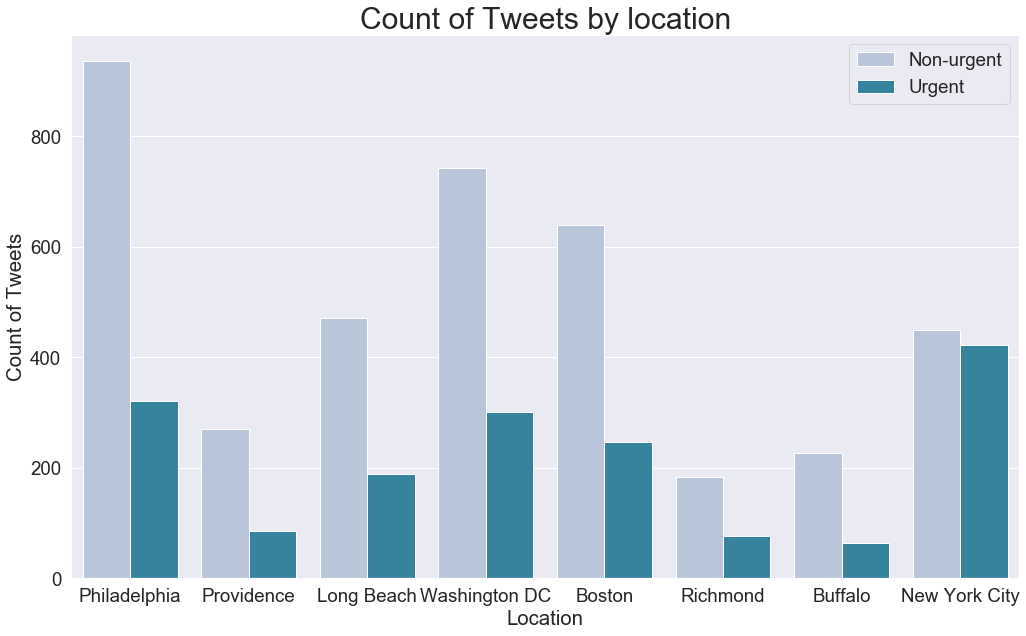

In [20]:
#Plotting Counts of tweets per city 
plt.figure(figsize=(17,10))
sns.set(font_scale=1.7)
ax = sns.countplot(x='location', data=df, hue='urgent', palette= "PuBuGn");
    
#Set title, label and legend 
ax.set_title("Count of Tweets by location", fontsize = 30)
ax.set_ylabel("Count of Tweets")
ax.set_xlabel("Location")
plt.legend(labels=['Non-urgent', 'Urgent'])

#Save figure
plt.savefig('../images/count_tweets_location.png');

**Observation**: As already expected we have a higher count of non-urgent tweets in most of the city. However, New York City has a close count of non-urgent and urgent tweets, whereas Philadelphia has high number of non-urgent tweets and a low value of urgent tweets. 

We are going to create different columns for each city, where we are going to cumulatively count urgent tweets over time.

In [21]:
#Function to count urgent tweets
def count_city(df, city):
    #empty list
    city_list = []
    
    #Iterating through each row 
    for index,rows in enumerate(df['location']):
        if rows == city:
            city_list.append(df['urgent'][index])
        else:
            city_list.append(0)
    
    return np.cumsum(city_list)

In [22]:
#Test function
count_city(df, city='Boston')

array([  0,   0,   0, ..., 268, 269, 269])

In [23]:
#Iterating through each city in df['location'] and applying function
for cities in df['location'].unique():
    df[cities] = count_city(df, city=cities)

In [24]:
#Eliminating columns that are not needed anymore 
df.drop(columns=['urgent', 'location'], inplace=True)

In [25]:
#Results
df.head()

,timestamp,Philadelphia,Providence,Long Beach,Washington DC,Boston,Richmond,Buffalo,New York City
2143,2012-10-27 00:04:07,1,0,0,0,0,0,0,0
2499,2012-10-27 00:09:27,1,0,0,0,0,0,0,0
3984,2012-10-27 00:10:29,1,0,0,0,0,0,0,0
3542,2012-10-27 00:11:59,1,0,0,1,0,0,0,0
2142,2012-10-27 00:18:58,1,0,0,1,0,0,0,0


In [26]:
#Results
df.tail()

,timestamp,Philadelphia,Providence,Long Beach,Washington DC,Boston,Richmond,Buffalo,New York City
3625,2012-11-12 23:43:21,372,113,226,318,267,77,97,235
4208,2012-11-12 23:46:53,372,113,226,318,267,77,97,235
475,2012-11-12 23:51:44,372,113,226,318,268,77,97,235
474,2012-11-12 23:55:21,372,113,226,318,269,77,97,235
2811,2012-11-12 23:58:10,372,113,226,318,269,77,97,235


Now we have a data frame where we have cumulatively count urgent tweets in each location over time. We are going to save this new data frame to continue with mapping 

In [27]:
#Saving data frame 
df.to_csv('../data/df_mapping.csv', index_label=False)